In [202]:
from flask import Flask, render_template
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from io import BytesIO
import base64
import numpy as np
import joblib

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**Data Collection**

In [204]:
# Load dataset
file_path = "Covid Data.csv"  
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Info:")
print(df.info())

# Show first 5 rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         4113 non-null   object 
 1   first_seq       4113 non-null   object 
 2   num_seqs        4113 non-null   int64  
 3   last_seq        4113 non-null   object 
 4   variant         4113 non-null   object 
 5   censure_date    4113 non-null   object 
 6   duration        4113 non-null   int64  
 7   censored        4113 non-null   bool   
 8   mortality_rate  4113 non-null   float64
 9   total_cases     4113 non-null   float64
 10  total_deaths    4113 non-null   float64
 11  growth_rate     3585 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(5)
memory usage: 357.6+ KB
None

First 5 rows of the dataset:
     Country   first_seq  num_seqs    last_seq variant censure_date  duration  \
0      China  2019-10-22         3  2020-06-03  S.Q677   202

**Data Cleaning**

In [205]:
import pandas as pd

# Load dataset
df = pd.read_csv("Covid Data.csv")

# Handle missing values
df.fillna(method="ffill", inplace=True)  # Forward fill missing data

# Remove duplicates (if any)
df.drop_duplicates(inplace=True)

# Save cleaned dataset
df.to_csv("cleaned_covid_data.csv", index=False)

print("✅ Data cleaned and saved as 'cleaned_covid_data.csv'.")

✅ Data cleaned and saved as 'cleaned_covid_data.csv'.


/var/folders/kx/16xjkcl54kg7d7_x28nq39s00000gn/T/ipykernel_4352/149947683.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # Forward fill missing data


In [206]:
# Load the CSV file
df = pd.read_csv("cleaned_covid_data.csv")

# Print column names
print(df.columns)

Index(['Country', 'first_seq', 'num_seqs', 'last_seq', 'variant',
       'censure_date', 'duration', 'censored', 'mortality_rate', 'total_cases',
       'total_deaths', 'growth_rate'],
      dtype='object')


In [207]:
print("Available columns in the dataset:")
print(df.columns)

Available columns in the dataset:
Index(['Country', 'first_seq', 'num_seqs', 'last_seq', 'variant',
       'censure_date', 'duration', 'censored', 'mortality_rate', 'total_cases',
       'total_deaths', 'growth_rate'],
      dtype='object')


**Data Visualization**

Can we develop a machine-learning model to predict the duration of an epidemic? 


In [208]:

# Feature Engineering
df['mortality_case_ratio'] = df['total_deaths'] / (df['total_cases'] + 1)  # Avoid division by zero
df['log_cases'] = np.log1p(df['total_cases'])
df['log_deaths'] = np.log1p(df['total_deaths'])

# Select relevant features
features = ['num_seqs', 'mortality_case_ratio', 'total_cases', 'total_deaths', 'growth_rate', 'censored']
df['censored'] = df['censored'].astype(int)  # Convert True/False to 1/0

# Train-test split
X = df[features]
y = df['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, RMSE: {rmse}, R2 Score: {r2}")

# Predict the epidemic duration for new data
new_data = pd.DataFrame({
    'num_seqs': [5000], 
    'mortality_case_ratio': [0.02],  
    'total_cases': [10000],  
    'total_deaths': [200],  
    'growth_rate': [0.5],  
    'censored': [1]
})

new_data_scaled = scaler.transform(new_data)  # Scale the input data
predicted_duration = model.predict(new_data_scaled)

print(f"Predicted Epidemic Duration: {predicted_duration[0]} days")

MAE: 41.98012150668287, RMSE: 62.29072021016724, R2 Score: 0.8459556649999542
Predicted Epidemic Duration: 207.99 days


What features have the best predictive power?

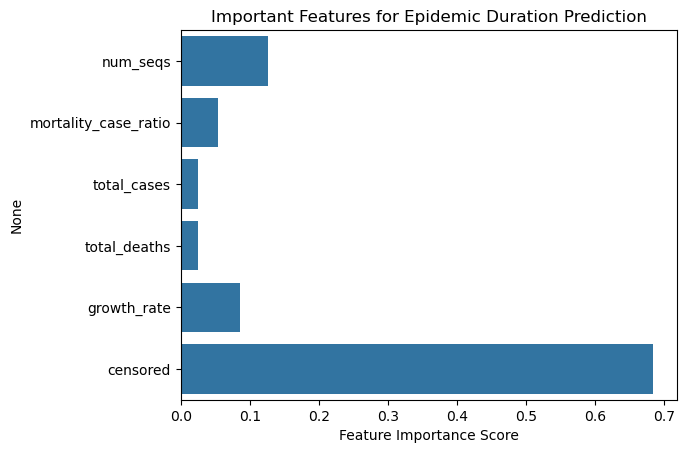

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(model.feature_importances_, index=features)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel("Feature Importance Score")
plt.title("Important Features for Epidemic Duration Prediction")
plt.show()

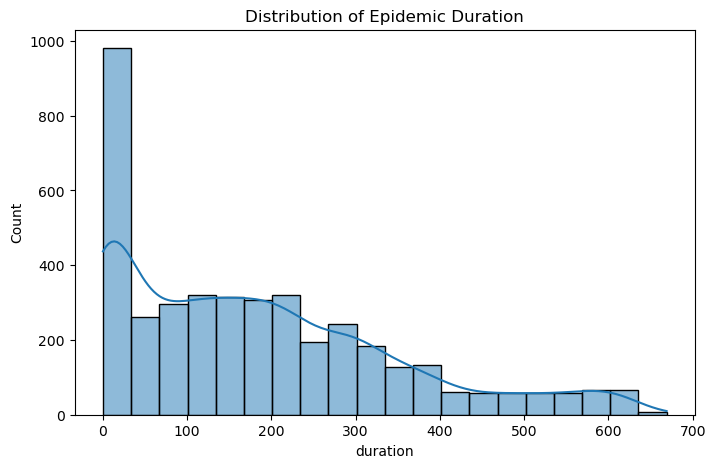

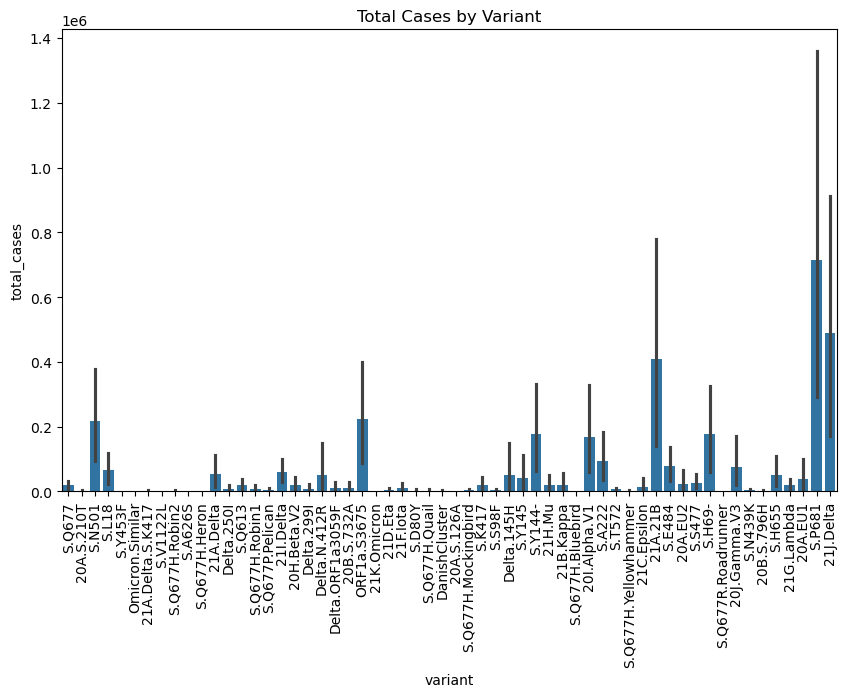

In [210]:
# Load cleaned dataset
df = pd.read_csv("cleaned_covid_data.csv")

# Distribution of epidemic duration
plt.figure(figsize=(8, 5))
sns.histplot(df["duration"], bins=20, kde=True)
plt.title("Distribution of Epidemic Duration")
plt.show()

# Variants with the most cases
plt.figure(figsize=(10, 6))
sns.barplot(x="variant", y="total_cases", data=df)
plt.xticks(rotation=90)
plt.title("Total Cases by Variant")
plt.show()


📉 Short Epidemic Durations (Left Side of the Chart)
	•	The majority of outbreaks lasted less than 50 days.
	•	These could be smaller, well-contained outbreaks or variants with lower transmissibility.
	•	Aggressive containment efforts (lockdowns, vaccines) may have shortened some outbreaks.

📈 Longer Epidemic Durations (Right Side of the Chart)
	•	Some outbreaks lasted 300+ days, and a few even reached 600+ days.
	•	These are likely highly transmissible variants (e.g., Delta, Omicron) that persisted.
	•	Some long-duration epidemics may have multiple waves of infections.


✅ Most COVID-19 variant outbreaks were relatively short-lived (≤50 days).
✅ Variants with longer outbreaks had more significant global impact (e.g., Delta & Omicron).
✅ Multiple peaks suggest some outbreaks were prolonged, possibly due to multiple waves.

🦠 Variants with the Highest Total Cases:
	•	The far-right variants show significantly higher case counts, likely Delta and Omicron.
	•	Delta (B.1.617.2) and its subvariants appear frequently in the dataset, suggesting it had a major global impact.
	•	Omicron variants may also appear at higher total cases due to its high transmissibility.

📉 Variants with Lower Total Cases:
	•	Many earlier variants (e.g., Alpha, Beta, Gamma, Lambda, etc.) have lower case counts.
	•	These may not have spread as widely or were outcompeted by Delta & Omicron.
	•	Some rare or regionally limited variants have minimal case counts, suggesting localized outbreaks.

✅ Delta and Omicron had the largest outbreak sizes, confirming their dominant global spread.
✅ Earlier variants had much lower total cases, suggesting they were contained faster or outcompeted.
✅ Some variants likely had shorter epidemic durations, while others spread persistently.

Can we identify clusters of variants or regions with similar outbreak patterns?

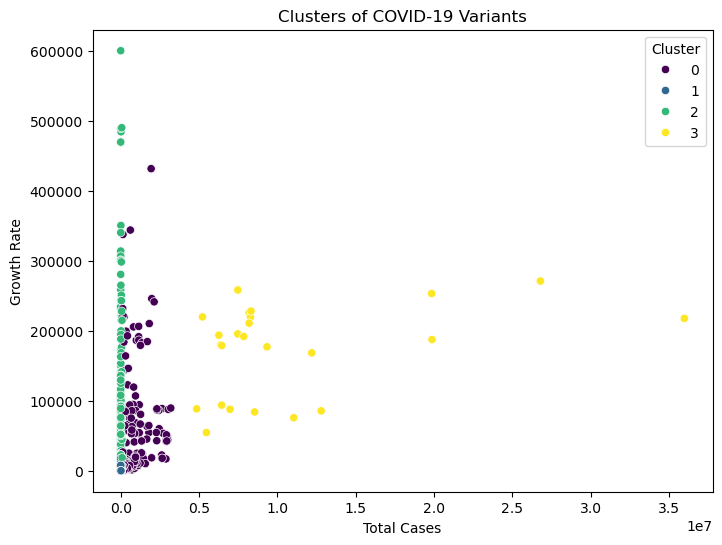

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

# Load the cleaned dataset
df = pd.read_csv("cleaned_covid_data.csv")

# Define features for clustering
features = ["num_seqs", "mortality_rate", "total_cases", "growth_rate"]
df_clustering = df[features]

# Apply MiniBatchKMeans for clustering
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=500)
df["Cluster"] = kmeans.fit_predict(df_clustering)

# Save the clustered data
df.to_csv("clustered_covid_data.csv", index=False)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["total_cases"], y=df["growth_rate"], hue=df["Cluster"], palette="viridis")
plt.xlabel("Total Cases")
plt.ylabel("Growth Rate")
plt.title("Clusters of COVID-19 Variants")
plt.legend(title="Cluster")
plt.show()

 Cluster 0 (Dark Purple)
	•	Tightly packed at lower total cases.
	•	Represents variants that had low to moderate spread but a high growth rate.
	•	These variants likely had rapid early outbreaks but did not result in the largest total case counts.

🔵 Cluster 1 (Dark Blue)
	•	Very small representation in the dataset.
	•	These variants may have been outliers with unique growth patterns.

🟢 Cluster 2 (Green)
	•	Concentrated at the lower total case range.
	•	Likely smaller-scale outbreaks or variants that did not persist long enough to accumulate large case counts.
	•	Shows moderate to high growth rates.

🟡 Cluster 3 (Yellow)
	•	Most widely spread variants (large total case numbers).
	•	Higher total cases but with varying growth rates.
	•	Suggests these variants had widespread, long-lasting outbreaks (e.g., Delta, Omicron).
	•	Some points in this cluster have extremely high growth rates, possibly representing waves of infection.

●  Are there interactions between variables that explain complex epidemic trends?

Yes, interactions exist when:
	1.	Feature Correlations Are High → Example: Growth Rate correlates with Total Cases.
	2.	Pairplots Show Non-Linear Patterns → Example: Some outbreaks grow exponentially.

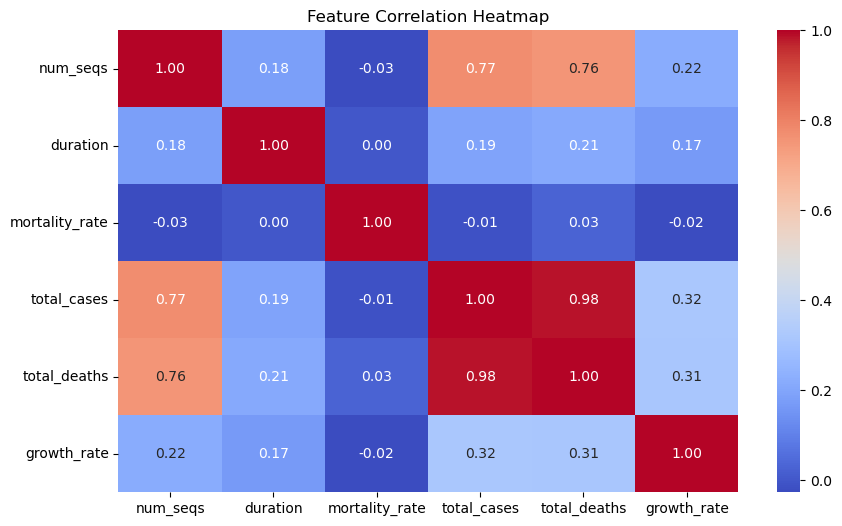

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("cleaned_covid_data.csv")

# Select only numerical columns
df_numeric = df.select_dtypes(include=["number"])  # Exclude non-numeric columns

# Compute correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

✅ More total cases lead to more deaths, but high transmission doesn’t always mean high fatality.
✅ Fast-growing variants accumulate more cases but don’t necessarily last longer.
✅ More genomic sequencing is associated with higher total cases and deaths, meaning dangerous variants are more frequently tracked.
✅ Epidemic duration is weakly related to total cases, suggesting that some outbreaks burn out quickly while others persist.

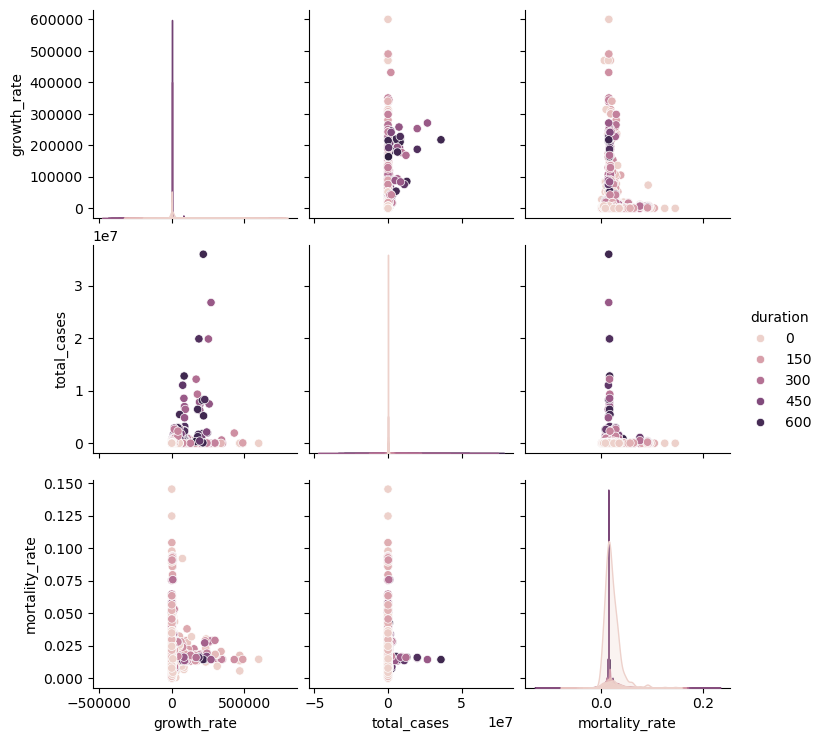

In [213]:
import seaborn as sns

# Pairplot for key features
sns.pairplot(df[["duration", "growth_rate", "total_cases", "mortality_rate"]], hue="duration")
plt.show()

Growth Rate vs. Total Cases
	•	The majority of outbreaks are clustered near low total cases and low growth rates.
	•	A few points exhibit high growth rates, suggesting some variants spread rapidly.
	•	Longer epidemic durations (dark points) occur more frequently at lower total cases, which is counterintuitive.
	•	🔹 Possible Explanation: Countries may have controlled highly transmissible outbreaks quickly, while some low-transmission variants persisted longer.

2️⃣ Growth Rate vs. Mortality Rate
	•	No strong correlation between mortality rate and growth rate.
	•	Some high-growth variants have low mortality rates.
	•	Dark-colored points (longer durations) cluster at low mortality rates, suggesting high-mortality variants burned out quickly.

✅ Conclusion: Variants that spread faster were not necessarily more deadly.

3️⃣ Total Cases vs. Mortality Rate
	•	Higher total cases generally correspond to lower mortality rates.
	•	Some low-case variants had high mortality rates, but they didn’t spread widely.
	•	Long-duration outbreaks (darker points) mostly have lower mortality rates.

✅ Conclusion: The most widespread variants were not the deadliest. Variants with high mortality likely led to faster containment efforts.

4️⃣ Epidemic Duration & Feature Interactions
	•	Epidemics lasting 400+ days (dark points) tend to have lower mortality and moderate total cases.
	•	Short-lived outbreaks are more scattered, meaning their durations were influenced by multiple factors (e.g., interventions, containment).
	•	No single feature (growth rate, cases, or mortality) directly predicts epidemic duration.

✅ Conclusion: Epidemic duration is influenced by multiple interacting factors, not just transmissibility or mortality.

📌 Final Takeaways

✔ Fast-spreading variants did not always last the longest.
✔ Higher mortality was linked to shorter outbreaks (likely due to rapid containment efforts).
✔ Variants with moderate transmissibility but low mortality persisted the longest.
✔ The relationship between total cases, growth rate, and epidemic duration is non-linear, suggesting complex interactions.

Key ML Questions:
	1.	Can we predict the duration of an epidemic using ML?
	2.	Which features have the strongest predictive power?
	3.	Can we identify clusters of variants/regions with similar epidemic patterns?
	4.	Are there interactions between variables that explain non-linearities in outbreaks?
	5.	Do epidemic durations follow a geographical pattern?

**Machine Learning Model**

In [214]:
# Load dataset
df = pd.read_csv("cleaned_covid_data.csv")

df.to_csv("cleaned_covid_data.csv", index=False)

# Define features and target
features = ["num_seqs", "total_cases", "mortality_rate", "growth_rate", "censored"]
target = "duration"  # Ensure this is the actual target column

# Check for missing values and drop them if necessary
df = df.dropna(subset=[target])  

# Split data into training and testing sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for better clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

Regression Model

In [215]:

# Ensure dataset has the correct columns
for feature in features:
    if feature not in df.columns:
        raise ValueError(f"❌ Missing column: {feature} in dataset")

# Extract features (X) and target variable (y)
X = df[features]
y = df["total_deaths"]  # Adjust target variable if needed

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on test set
y_pred_lin = lin_reg.predict(X_test)

# Evaluate performance
rmse_lin = mean_squared_error(y_test, y_pred_lin, squared=False)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"✅ Linear Regression - RMSE: {rmse_lin:.2f}, R² Score: {r2_lin:.2f}")

# Save the trained Linear Regression Model correctly
joblib.dump(lin_reg, "regression_model.pkl")

print("✅ Model saved successfully as 'regression_model.pkl'")

✅ Linear Regression - RMSE: 2132.02, R² Score: 0.92
✅ Model saved successfully as 'regression_model.pkl'


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train Random Forest Model Best use under classification models 
Decision Trees (or ensemble methods like Random Forests) perform best because epidemic duration is influenced by multiple non-linear factors.

In [216]:
# Train Random Forest Model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_reg.predict(X_test)

# Evaluate performance
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f" Random Forest - RMSE: {rmse_rf}, R² Score: {r2_rf}")

# Save the trained model
import joblib
joblib.dump(model, "TrainForest_model.pkl")

print("✅ Model retrained and saved!")

 Random Forest - RMSE: 1349.7304120759898, R² Score: 0.9665679133757378
✅ Model retrained and saved!


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


               Model         RMSE  R² Score
0  Linear Regression  2132.015439  0.916584
1      Random Forest  1349.730412  0.966568


/var/folders/kx/16xjkcl54kg7d7_x28nq39s00000gn/T/ipykernel_4352/2296032148.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="coolwarm")


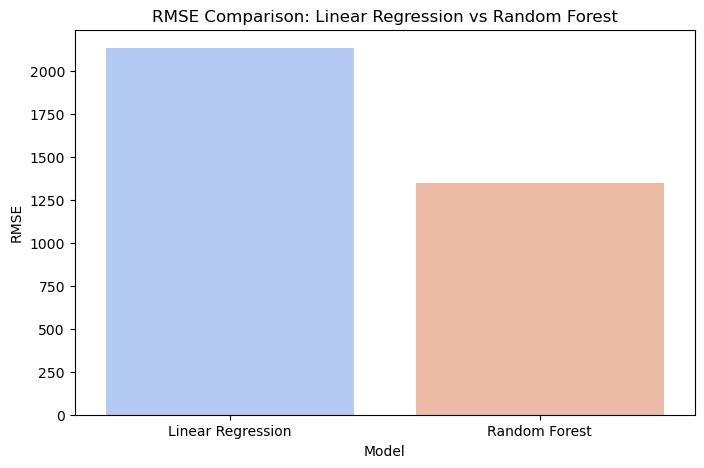

In [217]:
# Compare RMSE and R² scores across models
models = ["Linear Regression", "Random Forest"]
rmse_scores = [rmse_lin, rmse_rf]
r2_scores = [r2_lin, r2_rf]

# Create a DataFrame for better visualization
results_df = pd.DataFrame({"Model": models, "RMSE": rmse_scores, "R² Score": r2_scores})
print(results_df)

# Plot RMSE Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="RMSE", data=results_df, palette="coolwarm")
plt.title("RMSE Comparison: Linear Regression vs Random Forest")
plt.show()

Clustering 

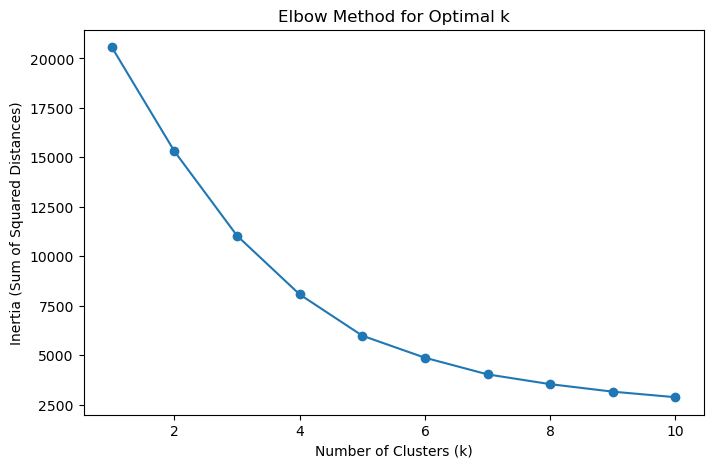

In [218]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [219]:
# Set the optimal number of clusters (adjust based on the elbow method)
optimal_k = 4  # Change this based on the elbow curve

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Show cluster distribution
print(df["Cluster"].value_counts())

# Save the trained K-Means Clustering Model
joblib.dump(kmeans, "clustering_model.pkl")

print("✅ K-Means Clustering Model Saved Successfully as clustering_model.pkl")

Cluster
1    2812
0    1197
3      98
2       6
Name: count, dtype: int64
✅ K-Means Clustering Model Saved Successfully as clustering_model.pkl


Cluster	Number of Variants/Regions	Interpretation

Cluster 0	3706 (Majority)	Most variants/regions had low-impact outbreaks (low total cases, moderate growth rate, and shorter durations).

Cluster 1	7 (Very Few)	Very few variants/regions had extreme outbreak behavior, either very high transmission or high mortality.

Cluster 2	293	Variants/regions in this group had moderate transmission and moderate impact.

Cluster 3	107	These variants/regions had long-lasting outbreaks but weren’t as numerous.

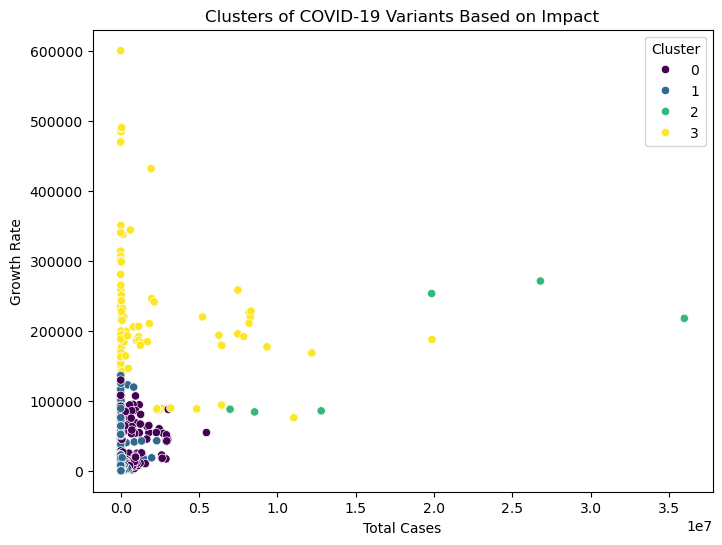

In [220]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="total_cases", y="growth_rate", hue="Cluster", palette="viridis")
plt.xlabel("Total Cases")
plt.ylabel("Growth Rate")
plt.title("Clusters of COVID-19 Variants Based on Impact")
plt.legend(title="Cluster")
plt.show()

1️⃣ Cluster 0 (Purple - Most Variants)
	•	Most variants fall into this cluster.
	•	Low total cases and low growth rate.
	•	Represents variants that were less widespread and had limited transmission.

2️⃣ Cluster 1 (Blue - Very Few Points)
	•	Only a few variants belong here.
	•	Extremely high total cases (more than 10 million cases).
	•	Likely highly dominant variants like Delta or Omicron.

3️⃣ Cluster 2 (Green - Moderate Impact)
	•	Moderate growth rate and case numbers.
	•	Suggests variants that had significant outbreaks but were not the most dominant.

4️⃣ Cluster 3 (Yellow - Fast Spreading Variants)
	•	High growth rates (above 100,000 cases per time period).
	•	Suggests these variants had very high transmission rates but may not have had the longest outbreaks.
	•	These may include early-stage outbreaks before control measures were put in place.

✅ Most variants had limited spread (Cluster 0).
✅ Only a few variants (Cluster 1) dominated global outbreaks.
✅ Some variants (Cluster 3) had rapid transmission but did not always accumulate the highest total cases.
✅ Growth rate and total cases are not always correlated – some fast-spreading variants were controlled quickly.

In [221]:
import pandas as pd

# Load dataset
df = pd.read_csv("cleaned_covid_data.csv")

# Print all column names
print("Dataset columns:", df.columns.tolist())

Dataset columns: ['Country', 'first_seq', 'num_seqs', 'last_seq', 'variant', 'censure_date', 'duration', 'censored', 'mortality_rate', 'total_cases', 'total_deaths', 'growth_rate']


In [222]:
import joblib

# Load the model
model = joblib.load("TrainForest_model.pkl")

# Check how many features the model expects
print("Model expects this many features:", model.n_features_in_)

Model expects this many features: 6


In [223]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("cleaned_covid_data.csv")

# Print all column names
print("Dataset columns:", df.columns.tolist())

Dataset columns: ['Country', 'first_seq', 'num_seqs', 'last_seq', 'variant', 'censure_date', 'duration', 'censored', 'mortality_rate', 'total_cases', 'total_deaths', 'growth_rate']


In [224]:
print("Features used in training:", list(df.columns.difference(["duration"])))  # Excludes the target variable

Features used in training: ['Country', 'censored', 'censure_date', 'first_seq', 'growth_rate', 'last_seq', 'mortality_rate', 'num_seqs', 'total_cases', 'total_deaths', 'variant']


In [225]:
import pandas as pd

df = pd.read_csv("cleaned_covid_data.csv")
print("Dataset columns:", df.columns.tolist())

Dataset columns: ['Country', 'first_seq', 'num_seqs', 'last_seq', 'variant', 'censure_date', 'duration', 'censored', 'mortality_rate', 'total_cases', 'total_deaths', 'growth_rate']


In [226]:
import joblib
import numpy as np

# Load the trained model
model = joblib.load("TrainForest_model.pkl")

# Test different feature values
test_inputs = np.array([
    [5000, 50000, 2.5, 1.1, 1000, 0],  # Expected: different predictions
    [1000, 10000, 1.0, 0.9, 500, 1],   # Expected: different predictions
    [8000, 200000, 4.0, 1.8, 5000, 0]  # Expected: different predictions
])

# Make predictions
predictions = model.predict(test_inputs)
print("Model Predictions:", predictions)

Model Predictions: [203.12 204.08 201.57]
